# General setup

In [2]:
import os, sys, subprocess
import time
from glob import glob
import itertools
from functools import partial
import copy
import gc

import importlib
sys.path.insert(1, os.path.realpath('lib'))
if "utils" not in sys.modules: import utils
else: importlib.reload(utils)
if "ml" not in sys.modules: import ml
else: importlib.reload(ml)
if "train" not in sys.modules: import train
else: importlib.reload(train)

# >>> exclude from multiprocessing
import ipynbname
nb_base = ipynbname.name().split('_')[0]
# <<<

import numpy as np

# >>> exclude from multiprocessing
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib import ticker
import h5py
# <<<

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
if not utils.is_notebook():
    import torch.multiprocessing as mp

In [3]:
# >>> exclude from multiprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# <<<

Using cuda device


# Loading Data

In [5]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

raw_train_dataset = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

raw_test_dataset = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

Shape of X [N, C, H, W]:  torch.Size([16, 1, 28, 28])
Shape of y:  torch.Size([16]) torch.int64
Shape of z:  torch.Size([16]) torch.int64


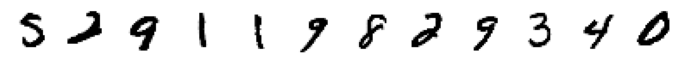

tensor([5, 2, 9, 1, 1, 9, 8, 2, 9, 3, 4, 0])
tensor([14, 12, 12,  0, 13, 19, 16,  6,  6, 13, 17, 19])


In [10]:
# >>> exclude from multiprocessing
# Example batch
preview_dataloader = DataLoader(
    ml.RelabeledSubset(raw_train_dataset, class_size=100,
                       target2_config=20, transform=transform),
    batch_size=16, shuffle=True)

X, y, z = next(iter(preview_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)
print("Shape of z: ", z.shape, z.dtype)
    
utils.plot_images(X.clamp_(-1, 1), num=12)
print(y[:12])
print(z[:12])
# <<<

# Training

In [32]:
HIDDEN_SIZE = 50
CLASS_SIZES = [200, 400, 600, 800, 1000]
num_sizes = len(CLASS_SIZES)
BATCH_SIZE = 50

DECORR_STRENGTH = 0.5
# Number of networks trained per class size
NUM_REPLICATES = 8

class_sizes = [rep
               for size in CLASS_SIZES
               for rep in (size,)*NUM_REPLICATES]*2
# Baseline networks then DeCorr networks
decorr_criteria = [rep
                   for criterion in (None, ml.decorr_criterion)
                   for rep in (criterion,)*NUM_REPLICATES*num_sizes]

# Evaluate digit classification performance with held-out test data
MODE = 'testval'

# Defining datasets for each replicate
train_datasets = [(
    ml.RelabeledSubset,
    dict(dataset=raw_train_dataset, class_size=class_size,
         target2_config='none', transform=transform)
) for class_size in class_sizes]
test_dataset = (
    ml.RelabeledSubset,
    dict(dataset=raw_test_dataset,
         target2_config='none', transform=transform)
)

# Defining multilayer perceptron
model = (
    ml.MLP,
    dict(hidden_size=HIDDEN_SIZE, target_size=10,
         nonlinearity1=nn.Tanh(), nonlinearity2=nn.Tanh())
)

# Looping through GPUs
devices = itertools.cycle([torch.device('cuda', i)
                           for i in range(torch.cuda.device_count())])

In [33]:
NUM_EPOCHS = 40
PRINT_EPOCHS = NUM_EPOCHS
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0
NOISE_FN = None

In [34]:
# Training keyword arguments that vary across replicates
kwargs_map = [dict(device=dev,
                   train_dataset=param0,
                   decorr_criterion=param1)
               for dev, param0, param1
               in zip(devices,
                      train_datasets,
                      decorr_criteria)]
# Training keyword arguments that remain constant
kwargs_partial = dict(model=model,
                      mode=MODE,
                      test_dataset=test_dataset,
                      decorr_strength=DECORR_STRENGTH,
                      noise_fn=NOISE_FN,
                      batch_size=BATCH_SIZE,
                      learning_rate=LEARNING_RATE,
                      num_epochs=NUM_EPOCHS,
                      print_epochs=PRINT_EPOCHS)
# >>> exclude from multiprocessing
kwargs_map[0]
# <<<

{'device': device(type='cuda', index=0),
 'train_dataset': (ml.RelabeledSubset,
  {'dataset': Dataset MNIST
       Number of datapoints: 60000
       Root location: ../../../PyTorchShared/Datasets
       Split: Train
       StandardTransform
   Transform: Compose(
                  ToTensor()
                  Normalize(mean=(0.1307,), std=(0.3081,))
              ),
   'class_size': 200,
   'target2_config': 'none',
   'transform': Compose(
       ToTensor()
       Normalize(mean=(0.1307,), std=(0.3081,))
   )}),
 'decorr_criterion': None}

In [35]:
# >>> exclude from multiprocessing
# Example training
i_train = 1
print(model)
utils.start_timer()
result = train.train(
    **(kwargs_partial | {'print_epochs': 2}),
    **kwargs_map[i_train]
)
utils.end_timer_and_print()
# <<<

(<class 'ml.MLP'>, {'hidden_size': 50, 'target_size': 10, 'nonlinearity1': Tanh(), 'nonlinearity2': Tanh()})
cuda:1   0)   target:  1.929  decorr:  8.156   train: 0.528  test: 0.689
cuda:1   1)   target:  1.211  decorr:  8.939   train: 0.765  test: 0.787
cuda:1   3)   target:  0.580  decorr:  8.400   train: 0.864  test: 0.853
cuda:1   5)   target:  0.384  decorr:  7.807   train: 0.908  test: 0.876
cuda:1   7)   target:  0.287  decorr:  7.670   train: 0.938  test: 0.890
cuda:1   9)   target:  0.225  decorr:  7.442   train: 0.953  test: 0.894
cuda:1  11)   target:  0.179  decorr:  7.436   train: 0.966  test: 0.897
cuda:1  13)   target:  0.147  decorr:  7.237   train: 0.973  test: 0.898
cuda:1  15)   target:  0.122  decorr:  7.173   train: 0.983  test: 0.898
cuda:1  17)   target:  0.099  decorr:  7.283   train: 0.989  test: 0.904
cuda:1  19)   target:  0.084  decorr:  7.104   train: 0.992  test: 0.902
cuda:1  21)   target:  0.070  decorr:  7.009   train: 0.995  test: 0.903
cuda:1  23)   t

In [36]:
# Only evaluate in multiprocessing script, not in notebook
if not utils.is_notebook():
    train_partial = partial(train.train, **kwargs_partial)
   
    # On NVIDIA V100 GPUs, each GPU can simultaneously train two networks
    MAX_PROCESSES = 2 * torch.cuda.device_count()
    
    # Use multiprocessing to train networks in parallel
    if __name__ == "__main__":
        utils.start_timer()
        mp.set_start_method('spawn', force=True)
        
        num_processes = min(len(kwargs_map), MAX_PROCESSES)
        with mp.Pool(num_processes) as p:
            results = utils.kwstarmap(p, train_partial, kwargs_map)

        utils.end_timer_and_print()

In [37]:
# >>$ exclude from multiprocessing until end of notebook
# Execute helper script to convert notebook to Python script
subprocess.call(["/bin/bash", "-c",
                 f"$(pwd)/converted/nb2script.sh {nb_base}.ipynb"])

[NbConvertApp] Converting notebook 1task-concept.ipynb to script
[NbConvertApp] Writing 7087 bytes to converted/1task-concept.py


0

In [39]:
# Run script using multiprocessing. Progress can be monitored using
# the jupyter terminal or by jupyterlab-nvdashboard
nb_script = f"converted/{nb_base}.py"
%run -i $nb_script

cuda:6   0)   target:  1.293  decorr:  8.143   train: 0.705  test: 0.858
cuda:6  39)   target:  0.010  decorr:  6.318   train: 1.000  test: 0.932
cuda:7   0)   target:  1.265  decorr:  9.002   train: 0.728  test: 0.863
cuda:7  39)   target:  0.010  decorr:  6.248   train: 1.000  test: 0.932
cuda:4   0)   target:  1.840  decorr:  3.871   train: 0.524  test: 0.742
cuda:4  39)   target:  0.040  decorr:  1.176   train: 1.000  test: 0.913
cuda:5   0)   target:  1.815  decorr:  3.782   train: 0.518  test: 0.758
cuda:5  39)   target:  0.040  decorr:  1.187   train: 1.000  test: 0.913
cuda:4   0)   target:  1.322  decorr:  8.530   train: 0.705  test: 0.869
cuda:4  39)   target:  0.009  decorr:  6.549   train: 1.000  test: 0.930
cuda:5   0)   target:  1.282  decorr:  8.349   train: 0.707  test: 0.859
cuda:5  39)   target:  0.010  decorr:  6.401   train: 1.000  test: 0.933
cuda:6   0)   target:  1.881  decorr:  3.916   train: 0.494  test: 0.760
cuda:6  39)   target:  0.040  decorr:  1.162   trai

# Results

In [40]:
# Collecting results across trained networks
losses = np.array([result[0] for result in results])
train_accuracies = np.array([result[1] for result in results])
test_accuracies = np.array([result[2] for result in results])

In [41]:
if "h5file" in globals():
    h5file.close()
h5file = h5py.File(f"out/{nb_base}.h5", 'w')

h5file.create_dataset("class_sizes", data=class_sizes)
h5file.create_dataset("losses", data=losses)
h5file.create_dataset("train_accuracies", data=train_accuracies)
h5file.create_dataset("test_accuracies", data=test_accuracies)

h5file.close()

In [42]:
sizes_by_criterion = np.array(class_sizes).reshape((2,-1))
accuracies_by_criterion = test_accuracies[:,-1].reshape((2,-1))

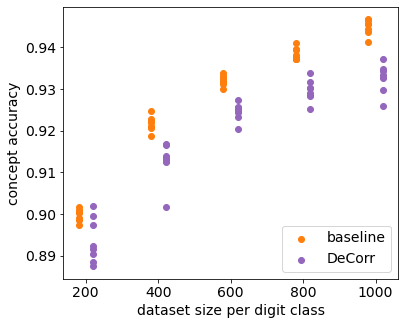

In [43]:
labels = ('baseline', 'DeCorr')
colors = ('tab:orange', 'tab:purple')
shift = 0.10
shift_facs = sizes_by_criterion[0, 0] * np.array((-shift, shift))

fig, ax = plt.subplots(figsize=(6, 5))
for sizes, accuracies, shift, color, label \
in zip(sizes_by_criterion, accuracies_by_criterion,
       shift_facs, colors, labels):
    ax.scatter(sizes + shift, accuracies, color=color, label=label)
ax.set_xticks(CLASS_SIZES)
ax.set_xlabel("dataset size per digit class")
ax.set_ylabel("concept accuracy")
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.legend(loc="lower right")
plt.show()